In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import scipy
import scipy.cluster
import scipy.io
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt

import sympy as sp

import lmfit
import numdifftools

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import collections

import optics_funs as of
import numerical_funs as nf
import matplotlib_funs as mpf
import LCT_funs as lctf
import general_funs as gef
import debug_funs as dgf
import stats_funs as sf
import wolfram_funs as wlf
import math_funs as mf

import beam_profiling

import new_types as nt
import mutants

In [5]:
def complex_cross_product(z1, z2):
    '''Treat complex numbers as vectors in R^2
    '''
    a,b = z1.real, z1.imag
    c,d = z2.real, z2.imag
    return a*d - b*c

def complex_dot_product(z1, z2):
    '''Treat complex numbers as vectors in R^2
    '''
    a,b = z1.real, z1.imag
    c,d = z2.real, z2.imag
    return a*c + b*d

In [6]:
def area_of_2_vectors(v1, v2):
    '''
    Compute area of two vectors by first finding their orthgonal components using SVD
    Then use area of ellipse formula.
    '''
#     print(f'{v1=} \n {v2=}')
    stack = np.vstack([v1,v2])
#     print(stack)
    U,S,V = np.linalg.svd(stack)
    area = np.pi * np.product(np.abs(S))
    return area

def vector_volume(V_basis):
    '''
    Compute volume of vector basis by first finding their orthgonal components using SVD
    Then use volume of N-ellipsoid formula.
    
    If the number of basis vectors is less than the dimension then the equation computes the
    N-volume where N is the number of vectors.
    '''
    N_dim, N_vectors = V_basis.shape
    assert(N_vectors <= N_dim)
    U,S,V = np.linalg.svd(V_basis)
    area = np.pi*(N_vectors/2) / scipy.special.gamma(N_vectors/2 + 1) * np.product(np.abs(S))
    return area

In [7]:
def test_fun(a,b):
    print(f'{a=} \n {b=}')
    return np.max(np.hstack([a,b]))

ff = np.vectorize(test_fun, signature='(k),(k)->()')

In [8]:
r1s = np.random.randn(2,3,4)
r2s = np.random.randn(2,3,4)

In [9]:
ff = np.vectorize(area_of_2_vectors, signature='(k),(k)->()')

In [10]:
q = 1j
d = 1
p1s = np.linspace(-10,10,201)
p2s = np.linspace(-1,3,202)
dp1 = 1e-7
dp2 = 1e-7
p1sa = p1s+dp1
p2sa = p2s+dp2

s1 = of.abcd.space(d)
f1s = of.abcd.lens_p(p1s)
f2s = of.abcd.lens_p(p2s)
f1sa = of.abcd.lens_p(p1sa)
f2sa = of.abcd.lens_p(p2sa)

ms = gef.outer_matmul(f2s,s1@f1s)
ms1a = gef.outer_matmul(f2s,s1@f1sa)
ms2a = gef.outer_matmul(f2sa,s1@f1s)

q2s = of.q.propag(q,ms)
q2s1a = of.q.propag(q,ms1a)
q2s2a = of.q.propag(q,ms2a)

q_target = 2j - 3
overlap = 1 - of.mode_mismatch(q2s,q_target)

In [11]:
weight = np.exp(3*(1-1/overlap))

/tmp/ipykernel_7849/2637854740.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(p1s, p2s, weight)
/tmp/ipykernel_7849/2637854740.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


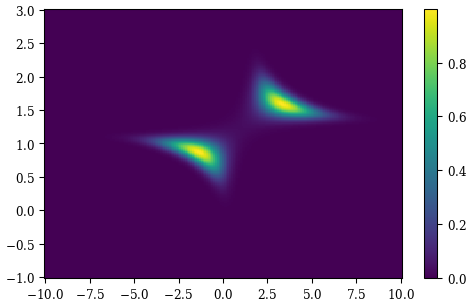

In [12]:
plt.pcolormesh(p1s, p2s, weight)
plt.colorbar()

In [13]:
def complex_to_R2(z):
    zr = np.real(z)
    zi = np.imag(z)
    return np.squeeze(np.dstack([zr,zi]).T)

In [14]:
dp1s = (q2s-q2s1a)/dp1
dp2s = (q2s-q2s2a)/dp2

In [15]:
svd_area = ff(complex_to_R2(dp1s).T, complex_to_R2(dp2s).T)

In [16]:
ac = np.abs(complex_cross_product(dp1s, dp2s))
ag = np.abs(dp1s)*np.abs(dp2s)
an = 1/2 * (np.abs(dp1s)**2 + np.abs(dp2s)**2)
ad = np.abs(complex_dot_product(dp1s, dp2s))
aa = (1-ad/an)

a_area = np.abs(dp1s)*np.abs(dp2s)*aa
a_orth = ac**2/ag**2
a_bal = ag/an
# a_ovl = 1 - of.mode_mismatch(q_out, q_target)

/tmp/ipykernel_7849/3158372004.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(p1s, p2s, a_bal * a_orth * a_area * overlap**2)
/tmp/ipykernel_7849/3158372004.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


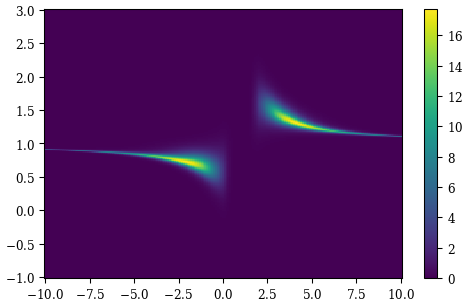

In [17]:
plt.pcolormesh(p1s, p2s, a_bal * a_orth * a_area * overlap**2)
plt.colorbar()

/tmp/ipykernel_7849/1641073402.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(p1s, p2s, np.exp(9*(-1/svd_area))*weight)
/tmp/ipykernel_7849/1641073402.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


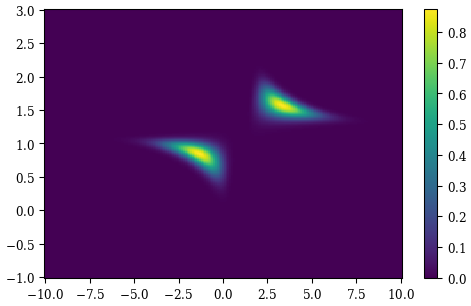

In [18]:
plt.pcolormesh(p1s, p2s, np.exp(9*(-1/svd_area))*weight)
plt.colorbar()

/tmp/ipykernel_7849/3097986378.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(p1s, p2s, a_bal**2 * a_orth**2 * svd_area)
/tmp/ipykernel_7849/3097986378.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


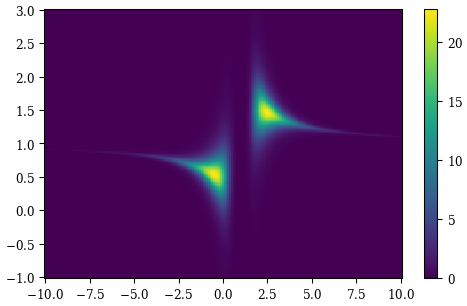

In [19]:
plt.pcolormesh(p1s, p2s, a_bal**2 * a_orth**2 * svd_area)
plt.colorbar()